# First ESN Model Using Keras

In [1]:
from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
import pandas as pd
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM, SimpleRNN
import plotly.offline as py
import plotly.graph_objs as go
import numpy as np
import seaborn as sns
py.init_notebook_mode(connected=True)
%matplotlib inline

Using TensorFlow backend.


In [2]:
data = pd.read_csv(filepath_or_buffer="./Data/clean_data_new.csv", index_col="date")

In [3]:
data.head()

,TCMNOM_Y10,TCMNOM_Y2,DCOILBRENTEU,spindx,GOLDPMGBD228NLBM,exalus,exjpus,exukus
date,,,,,,,,
19870520,8.92,8.05,18.63,278.21,475.25,1.3820,139.78,0.5942
19870521,8.87,8.06,18.45,280.17,469.10,1.3864,140.45,0.5956
19870522,8.78,7.97,18.55,282.16,466.50,1.3883,140.60,0.5977
19870526,8.55,7.79,18.63,289.11,449.00,1.4029,143.30,0.6120
19870527,8.60,7.84,18.60,288.73,449.50,1.3988,143.52,0.6200


In [4]:
data.tail()

,TCMNOM_Y10,TCMNOM_Y2,DCOILBRENTEU,spindx,GOLDPMGBD228NLBM,exalus,exjpus,exukus
date,,,,,,,,
20181029,3.08,2.81,77.56,2641.25,1230.80,1.4136,112.49,0.7808
20181030,3.12,2.84,75.68,2682.63,1225.40,1.4061,112.76,0.7855
20181031,3.15,2.87,74.84,2711.74,1214.95,1.4104,112.86,0.7825
20181101,3.14,2.84,71.25,2740.37,1231.15,1.3910,112.79,0.7708
20181102,3.22,2.91,71.11,2723.06,1232.10,1.3891,113.09,0.7713


In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7931 entries, 19870520 to 20181102
Data columns (total 8 columns):
TCMNOM_Y10          7931 non-null float64
TCMNOM_Y2           7931 non-null float64
DCOILBRENTEU        7931 non-null float64
spindx              7931 non-null float64
GOLDPMGBD228NLBM    7931 non-null float64
exalus              7931 non-null float64
exjpus              7931 non-null float64
exukus              7931 non-null float64
dtypes: float64(8)
memory usage: 557.6 KB


In [6]:
#data.DCOILBRENTEU.to_numericd
#data.GOLDPMGBD228NLBM = data.GOLDPMGBD228NLBM.astype(dtype = np.float64)
#data['GOLDPMGBD228NLBM'][0]
data = data.apply(pd.to_numeric, errors = "coerce")
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7931 entries, 19870520 to 20181102
Data columns (total 8 columns):
TCMNOM_Y10          7931 non-null float64
TCMNOM_Y2           7931 non-null float64
DCOILBRENTEU        7931 non-null float64
spindx              7931 non-null float64
GOLDPMGBD228NLBM    7931 non-null float64
exalus              7931 non-null float64
exjpus              7931 non-null float64
exukus              7931 non-null float64
dtypes: float64(8)
memory usage: 557.6 KB


In [7]:
btc_trace = go.Scatter(x=data.index, y=data['spindx'], name= 'spi')
py.iplot([btc_trace])

In [8]:
data['spindx'].replace(0, np.nan, inplace=True)
data['spindx'].fillna(method='ffill', inplace=True)

In [9]:
#reshaping prediction value into value range -1 to 1
from sklearn.preprocessing import MinMaxScaler

In [10]:
values = data['spindx'].values.reshape(-1,1)
values = values.astype('float32')
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)

In [11]:
values

array([[ 278.21],
       [ 280.17],
       [ 282.16],
       ...,
       [2711.74],
       [2740.37],
       [2723.06]], dtype=float32)

In [12]:
scaled

array([[0.02005667],
       [0.02078077],
       [0.02151594],
       ...,
       [0.9190898 ],
       [0.92966676],
       [0.9232718 ]], dtype=float32)

In [13]:
#split dataset into train and test, 70% train 30% test

In [14]:
train_size = int(len(scaled) * 0.7)
test_size = len(scaled) - train_size
train, test = scaled[0:train_size,:], scaled[train_size:len(scaled),:]
print(len(train), len(test))

5551 2380


In [15]:
#function that convert the dataset to be 3d
def create_dataset(dataset, look_back=1, predict_forward = 1-1): #predict_forward = 0 means predict the next day
    dataX, dataY = [], []
    for i in range(len(dataset) - look_back - predict_forward):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back+predict_forward, 0])
    print(len(dataY))
    return np.array(dataX), np.array(dataY)

In [16]:
look_back = 1 #use 3 previous days to predict the next day
predict_foward = 7 #user input
trainX, trainY = create_dataset(train, look_back, predict_foward-1)
testX, testY = create_dataset(test, look_back, predict_foward-1)

5544
2373


In [17]:
trainX[0]

array([0.02005667], dtype=float32)

In [18]:
trainY[0]

0.02434951

In [19]:
#reshaping data into 3-D
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [20]:
trainX

array([[[0.02005667]],

       [[0.02078077]],

       [[0.02151594]],

       ...,

       [[0.25318176]],

       [[0.25285295]],

       [[0.24382764]]], dtype=float32)

In [21]:
import random
random.seed(12345)

In [22]:
#run the model
model = Sequential()
model.add(SimpleRNN(200, input_shape=(trainX.shape[1], trainX.shape[2]),return_sequences=True, 
                    kernel_initializer='orthogonal', bias_initializer='zeros', trainable= False))
model.add(SimpleRNN(200,return_sequences=True))
model.add(SimpleRNN(200))
model.add(Dense(1))
model.compile(loss='mse', optimizer='rmsprop')


In [23]:
for wt in model.layers[0].get_weights():
    print(wt.shape)

(1, 200)
(200, 200)
(200,)


In [24]:
wt1, wt2, wt3 = model.layers[1].get_weights()

In [25]:
from numpy.linalg import eigvals
lambdas = eigvals(wt2)
spec_rad = max(lambdas)
np.absolute(spec_rad)

1.0

In [26]:
alpha = 0.5
model.layers[1].set_weights([wt1,alpha*wt2,wt3])

In [27]:
history = model.fit(trainX, trainY, epochs=50, batch_size=256, validation_data=(testX, testY), verbose=1, shuffle=True)

Train on 5544 samples, validate on 2373 samples
Epoch 1/50
5544/5544 [==============================] - 0s 66us/step - loss: 0.0065 - val_loss: 0.0388
Epoch 2/50
5544/5544 [==============================] - 0s 22us/step - loss: 0.0031 - val_loss: 4.6570e-04
Epoch 3/50
5544/5544 [==============================] - 0s 20us/step - loss: 0.0019 - val_loss: 0.0022
Epoch 4/50
5544/5544 [==============================] - 0s 18us/step - loss: 0.0018 - val_loss: 0.0028
Epoch 5/50
5544/5544 [==============================] - 0s 19us/step - loss: 0.0017 - val_loss: 0.0044
Epoch 6/50
5544/5544 [==============================] - 0s 19us/step - loss: 0.0016 - val_loss: 0.0019
Epoch 7/50
5544/5544 [==============================] - 0s 22us/step - loss: 0.0014 - val_loss: 0.0035
Epoch 8/50
5544/5544 [==============================] - 0s 21us/step - loss: 0.0014 - val_loss: 0.0072
Epoch 9/50
5544/5544 [==============================] - 0s 19us/step - loss: 0.0012 - val_loss: 0.0022
Epoch 10/50
5544/5544

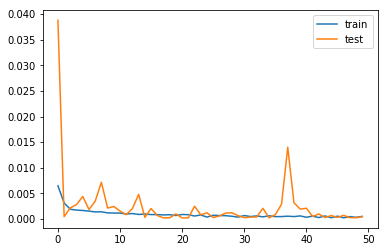

In [28]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

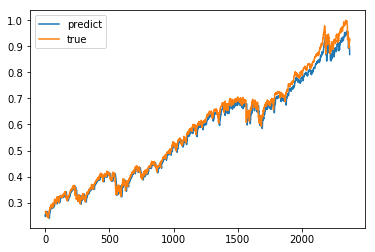

In [29]:
yhat = model.predict(testX)
pyplot.plot(yhat, label='predict')
pyplot.plot(testY, label='true')
pyplot.legend()
pyplot.show()

In [30]:
#inverse y back to values
yhat_inverse = scaler.inverse_transform(yhat.reshape(-1, 1))
testY_inverse = scaler.inverse_transform(testY.reshape(-1, 1))

In [31]:
rmse = sqrt(mean_squared_error(testY_inverse, yhat_inverse))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 57.831


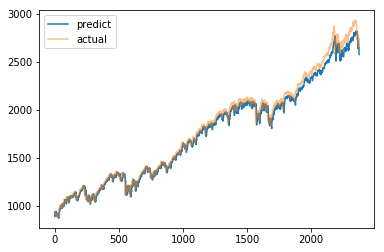

In [32]:
pyplot.plot(yhat_inverse, label='predict')
pyplot.plot(testY_inverse, label='actual', alpha=0.5)
pyplot.legend()
pyplot.show()

In [33]:
#convert back to normal 
predictDates = data.tail(len(testX)).index
testY_reshape = testY_inverse.reshape(len(testY_inverse))
yhat_reshape = yhat_inverse.reshape(len(yhat_inverse))

In [34]:
actual_chart = go.Scatter(x=predictDates, y=testY_reshape, name= 'Actual Price')
predict_chart = go.Scatter(x=predictDates, y=yhat_reshape, name= 'Predict Price')
py.iplot([predict_chart, actual_chart])